In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA

## Network
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt

from util import *
import data_loader as dl
import scdd as sd
import dist_deconv_1d as dd1d

%matplotlib inline
# %load_ext autoreload
# %autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [353]:
import matplotlib.cm as cm

In [144]:

data1mil = dl.load_10x_1_3mil()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [136]:
data68k = dl.load_10x_68k()
data8k = dl.load_10x_8k()
data4k = dl.load_10x_4k()
data1k = dl.load_10x_1k()
data2k = dl.load_10x_2k()
data9k = dl.load_10x_9k()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [145]:
mean_counts_68 = np.array(data68k.X.mean(axis=0)).reshape(-1)
mean_counts_8 = np.array(data8k.X.mean(axis=0)).reshape(-1)
mean_counts_4 = np.array(data4k.X.mean(axis=0)).reshape(-1)

mean_counts_1 = np.array(data1k.X.mean(axis=0)).reshape(-1)
mean_counts_2 = np.array(data2k.X.mean(axis=0)).reshape(-1)
mean_counts_9 = np.array(data9k.X.mean(axis=0)).reshape(-1)

mean_counts_1M = np.array(data1mil.X.mean(axis=0)).reshape(-1)

In [189]:
(np.sum(mean_counts_4)*data4k.shape[0]/1000000,
 np.sum(mean_counts_8)*data8k.shape[0]/1000000,
np.sum(mean_counts_68)*data68k.shape[0]/1000000
,
np.sum(mean_counts_1)*data1k.shape[0]/1000000
,
np.sum(mean_counts_2)*data2k.shape[0]/1000000
,
np.sum(mean_counts_9)*data9k.shape[0]/1000000)

(18.874818935546877,
 38.879905059082034,
 93.94007006494141,
 10.735863776367188,
 15.348747275390625,
 67.05353921875)

In [200]:
np.mean(mean_counts_9,90)

0.4226895809173583

In [212]:
mean_counts_68[mean_counts_68>0].mean()
mean_counts_4[mean_counts_4>0].mean()

0.21994825

In [219]:
(mean_counts_68>0).sum()

20387

In [215]:
1000000*(93.94007006494141/(mean_counts_8.sum()))

20249.836670585293

In [135]:
for t in [0,0.1,0.2]:

    print(t,(np.mean(mean_counts_68[mean_counts_68>t]),np.mean(mean_counts_8[mean_counts_8>t]),np.mean(mean_counts_4[mean_counts_4>t])))

0 (0.067190275, 0.21652524, 0.21994825)
0.1 (0.8419803, 1.0003264, 1.0008335)
0.2 (1.5557344, 1.7481219, 1.767765)


In [147]:
import seaborn as sns

In [163]:
sns.set_style('darkgrid')

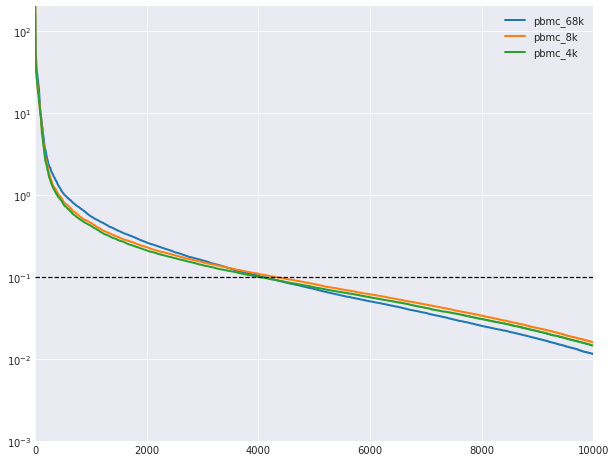

In [206]:
plt.figure(figsize=[10,8])
plt.semilogy(np.sort(mean_counts_68[mean_counts_68>0])[::-1],lw=2,label='pbmc_68k')
plt.semilogy(np.sort(mean_counts_8[mean_counts_8>0])[::-1],lw=2,label='pbmc_8k')
plt.semilogy(np.sort(mean_counts_4[mean_counts_4>0])[::-1],lw=2,label='pbmc_4k')

# plt.semilogy(np.sort(mean_counts_9[mean_counts_9>0])[::-1],lw=2,label='brain_9k')
# plt.semilogy(np.sort(mean_counts_2[mean_counts_2>0])[::-1],lw=2,label='brain_2k')
# plt.semilogy(np.sort(mean_counts_1[mean_counts_1>0])[::-1],lw=2,label='brain_1k')

# plt.semilogy(np.sort(mean_counts_1M[mean_counts_1M>0])[::-1],lw=2,label='brain_1M')

plt.legend()
plt.xlim([1,10000])
plt.ylim([.001,200])
# plt.xscale('log')
plt.hlines(0.1,xmin=1,xmax=10000,linestyles='--',lw=1.2,zorder=10)

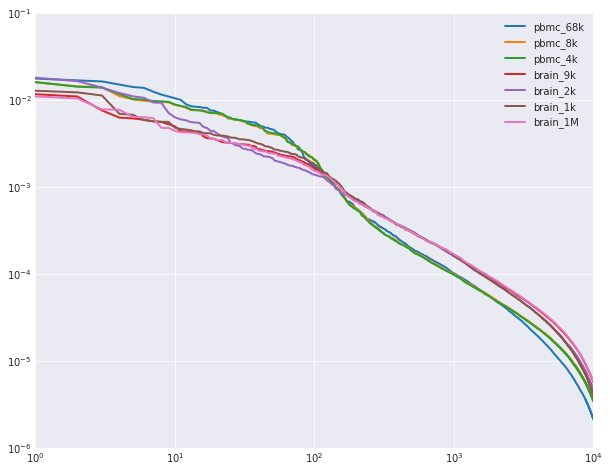

In [222]:
plt.figure(figsize=[10,8])
plt.semilogy(np.sort(mean_counts_68[mean_counts_68>0])[::-1]/mean_counts_68.sum(),lw=2,label='pbmc_68k')
plt.semilogy(np.sort(mean_counts_8[mean_counts_8>0])[::-1]/mean_counts_8.sum(),lw=2,label='pbmc_8k')
plt.semilogy(np.sort(mean_counts_4[mean_counts_4>0])[::-1]/mean_counts_4.sum(),lw=2,label='pbmc_4k')

plt.semilogy(np.sort(mean_counts_9[mean_counts_9>0])[::-1]/mean_counts_9.sum(),lw=2,label='brain_9k')
plt.semilogy(np.sort(mean_counts_2[mean_counts_2>0])[::-1]/mean_counts_2.sum(),lw=2,label='brain_2k')
plt.semilogy(np.sort(mean_counts_1[mean_counts_1>0])[::-1]/mean_counts_1.sum(),lw=2,label='brain_1k')

plt.semilogy(np.sort(mean_counts_1M[mean_counts_1M>0])[::-1]/mean_counts_1M.sum(),lw=2,label='brain_1M')

plt.legend()
plt.xlim([1,10000])
plt.ylim([.000001,0.1])
plt.xscale('log')
# plt.hlines(0.1,xmin=1,xmax=10000,linestyles='--',lw=1.2,zorder=10)

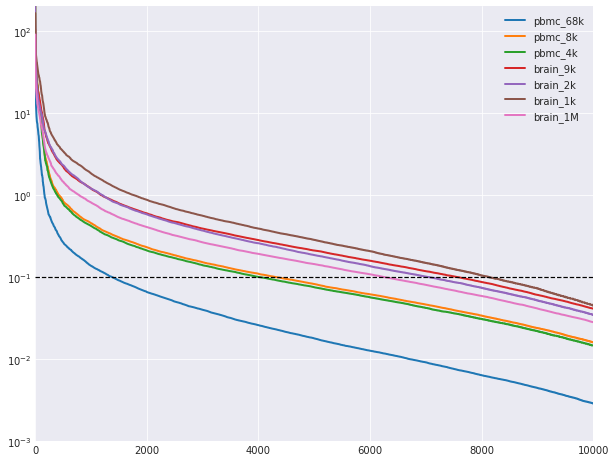

In [166]:
plt.figure(figsize=[10,8])
plt.semilogy(np.sort(mean_counts_68[mean_counts_68>0])[::-1],lw=2,label='pbmc_68k')
plt.semilogy(np.sort(mean_counts_8[mean_counts_8>0])[::-1],lw=2,label='pbmc_8k')
plt.semilogy(np.sort(mean_counts_4[mean_counts_4>0])[::-1],lw=2,label='pbmc_4k')

plt.semilogy(np.sort(mean_counts_9[mean_counts_9>0])[::-1],lw=2,label='brain_9k')
plt.semilogy(np.sort(mean_counts_2[mean_counts_2>0])[::-1],lw=2,label='brain_2k')
plt.semilogy(np.sort(mean_counts_1[mean_counts_1>0])[::-1],lw=2,label='brain_1k')

plt.semilogy(np.sort(mean_counts_1M[mean_counts_1M>0])[::-1],lw=2,label='brain_1M')

plt.legend()
plt.xlim([1,10000])
plt.ylim([.001,200])
# plt.xscale('log')
plt.hlines(0.1,xmin=1,xmax=10000,linestyles='--',lw=1.2,zorder=10)

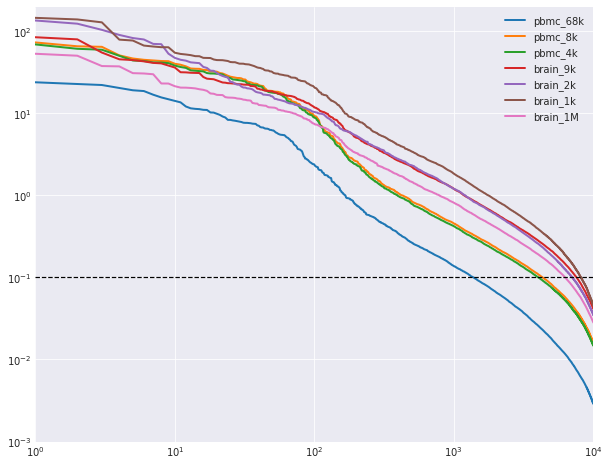

In [176]:
plt.figure(figsize=[10,8])
plt.semilogy(np.sort(mean_counts_68[mean_counts_68>0])[::-1],lw=2,label='pbmc_68k')
plt.semilogy(np.sort(mean_counts_8[mean_counts_8>0])[::-1],lw=2,label='pbmc_8k')
plt.semilogy(np.sort(mean_counts_4[mean_counts_4>0])[::-1],lw=2,label='pbmc_4k')

plt.semilogy(np.sort(mean_counts_9[mean_counts_9>0])[::-1],lw=2,label='brain_9k')
plt.semilogy(np.sort(mean_counts_2[mean_counts_2>0])[::-1],lw=2,label='brain_2k')
plt.semilogy(np.sort(mean_counts_1[mean_counts_1>0])[::-1],lw=2,label='brain_1k')

plt.semilogy(np.sort(mean_counts_1M[mean_counts_1M>0])[::-1],lw=2,label='brain_1M')

plt.legend()
plt.xlim([1,10000])
plt.ylim([.001,200])
plt.xscale('log')
plt.hlines(0.1,xmin=1,xmax=10000,linestyles='--',lw=1.2,zorder=10)

In [235]:
def mod_analysis(adj,gene_list=None,G_name='',min_node=5):
    
    if type(adj) == nx.classes.graph.Graph:
        G = adj
    else:
        G = nx.from_numpy_matrix(adj)
        
    if gene_list is None:
        gene_list = np.arange(G.number_of_nodes())
    print('Graph %s, n_node=%d, n_edge=%d'%(G_name,G.number_of_nodes(),G.number_of_edges()))
    partition = community_louvain.best_partition(G)
    mod_dic = partition_to_label(partition,min_node=min_node)
    
    mod_dic_ = mod_dic.copy()
    #print(mod_dic_)
    ## sort the nodes in each module by degree
    for key in mod_dic:
        H = G.subgraph(mod_dic[key])
        node_list = []
        degree_list = []
        for H_node,H_deg in H.degree:
            node_list.append(H_node)
            degree_list.append(H_deg)
        degree_list = np.array(degree_list)
        new_node_list = []
        for i_node in np.argsort(degree_list)[::-1]:
            new_node_list.append(node_list[i_node])
        mod_dic[key] = new_node_list 
    #return mod_dic
    for key in mod_dic.keys():
        print('Module %d, size=%d'%(int(key),len(mod_dic[key])))
        mod_dic[key] = gene_list[mod_dic[key]]
    return mod_dic

def check_marker_genes(mod_dic,marker_gene_dic):
    for key in marker_gene_dic:
        print('## Module %s'%key)
        for gene in marker_gene_dic[key]:
             for key_ in mod_dic.keys():
                if gene in mod_dic[key_]:
                    print('   %s: module %d'%(gene,key_))
        print(' ')
        
def partition_to_label(partition,min_node=5):
    mod_dic = {}
    for key in partition.keys():
        val = partition[key]
        if val not in mod_dic:
            mod_dic[val] = [key]
        else:
            mod_dic[val].append(key)
    key_list = list(mod_dic.keys())
    size_list = np.zeros([len(key_list)],dtype=int)
    
    for i_key,key in enumerate(key_list): 
        size_list[i_key] = len(mod_dic[key])
        
    mod_dic_new = {}
    for rank,i_key in enumerate(np.argsort(size_list)[::-1]):
        key = key_list[i_key]
        if size_list[i_key]>min_node:
            mod_dic_new[rank] = mod_dic[key] 
        
    return mod_dic_new

def draw_G(G,partition):
    #drawing
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))


    nx.draw_networkx_edges(G,pos, alpha=0.5)
    plt.show()

In [410]:
data = dl.load_10x_4k()
gene_list_raw = np.array(data.var_names)
sc.pp.filter_genes(data,min_counts=0.2*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=2133, Nr=3770.6, Nr_bar=1.8


In [411]:
%%time
# ## Subsample the data 
# Nc,G,Nr,Nr_bar = sd.get_info(data)
# Nr_new = Nr/2
# Nc_new = int(Nc/2)
# data_subsample = sd.subsample_anndata(data,Nr_new,Nc_new)

## MI using inactive probability 
size_factor = sd.dd_size_factor(data,verbose=False)
p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=0.55,size_factor=size_factor,verbose=True)
zero_matrix_ml,zero_matrix_dd = \
sd.dd_pairwise_inactive_prob(data,relative_depth=0.75,size_factor=size_factor,verbose=True)
smi_ml = sd.zero_to_mi(zero_matrix_ml,up_reg_gene=True) # zero probability to mi matrix 
smi_dd = sd.zero_to_mi(zero_matrix_dd,up_reg_gene=True)

# time start: 0.0s
n_cell=4340, n_gene=2133
# total time: 0.6s
# time start: 0.0s
n_cell=4340, n_gene=2133
# total time: 120.9s
CPU times: user 1min 53s, sys: 24.2 s, total: 2min 18s
Wall time: 2min 4s


In [412]:
gene_list= np.array(data.var_names)

In [417]:
save_dd = smi_dd.copy()

In [430]:
#filter zeros
nnz=np.where(save_dd.sum(axis=1)>0.0001)[0]
print(nnz.shape)

save_dd = save_dd[nnz,:][:,nnz]
gene_list_n=gene_list[nnz]

(1978,)


In [439]:


adj_csv = []

adj_csv= [['']+[i for i in gene_list_n]]
for i in range(len(gene_list_n)):
    adj_csv+= [ [gene_list_n[i]]+[i for i in save_dd[:,i]]  ]

In [429]:
import csv

In [442]:
myFile = open('./figures/figure_gene_network_VN/4k_dd_thresh.csv', 'w')
with myFile:
    writer = csv.writer(myFile,delimiter=';')
    writer.writerows(adj_csv)

In [452]:
## mi_dd
adj_mi_dd = smi_dd.copy()>0.03
# adj_mi_dd[adj_mi_dd<0.02]=0
np.fill_diagonal(adj_mi_dd,0)

#filter zeros
nnz=np.where(adj_mi_dd.sum(axis=1)>0)[0]
print(nnz.shape)

adj_mi_dd = np.array(adj_mi_dd[nnz,:][:,nnz],dtype=int)
gene_list_n=gene_list[nnz]

# G = nx.from_numpy_matrix(adj_mi_dd)

(1423,)


In [453]:
adj_csv = []

adj_csv= [['']+[i for i in gene_list_n]]
for i in range(len(gene_list_n)):
    adj_csv+= [ [gene_list_n[i]]+[str(i) for i in adj_mi_dd[:,i]]  ]
myFile = open('./figures/figure_gene_network_VN/4k_dd_thresh.csv', 'w')
with myFile:
    writer = csv.writer(myFile,delimiter=';')
    writer.writerows(adj_csv)

In [427]:
partition = community_louvain.best_partition(G)

In [364]:
labels = {}
s=nx.degree_centrality(G)
for idx, node in enumerate(G.nodes()):
    if s[idx]>0.1:
        labels[node] = gene_list[idx]
    else:
        labels[node] = ''

In [365]:
sns.set_style('white')

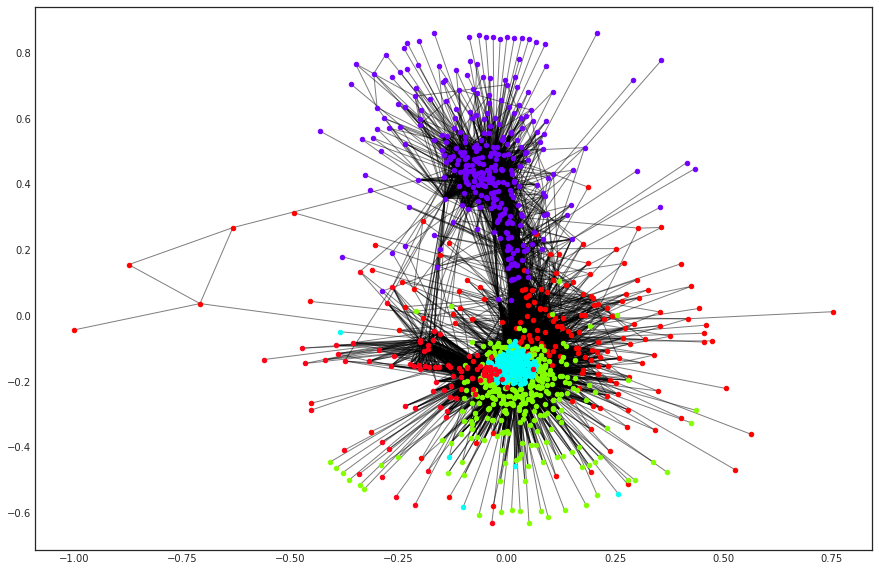

In [428]:
plt.figure(figsize=[15,10])
# nx.draw(G,linewidths=.1,node_size=30,edge_color='lightgray')#,labels=labels)
draw_G(G,partition)

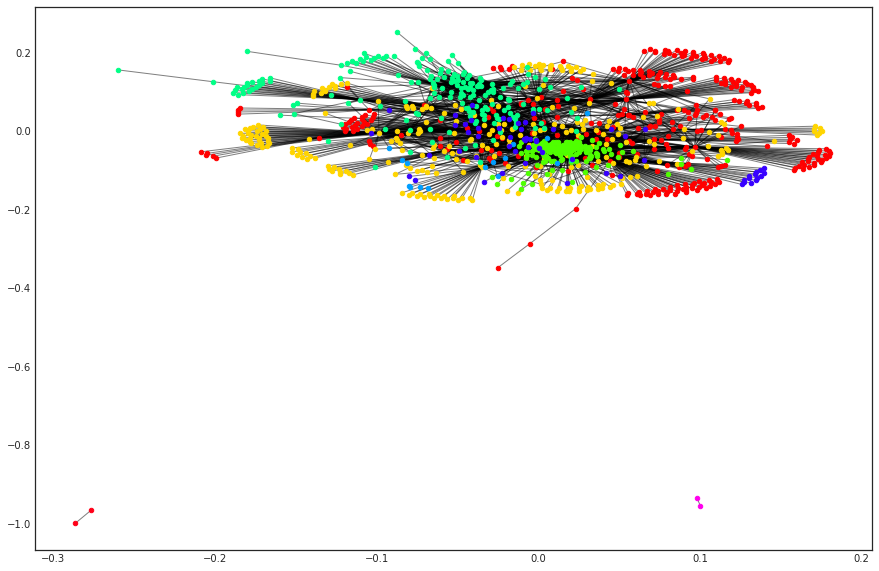

In [423]:
plt.figure(figsize=[15,10])
# nx.draw(G,linewidths=.1,node_size=30,edge_color='lightgray')#,labels=labels)
draw_G(G,partition)

In [359]:
def draw_G(G,partition):
    colors = iter(cm.hsv(np.linspace(0, 1, len(set(partition.values())))))
    #drawing
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                               node_color = next(colors))
#                                     node_color = str(count / size))


    nx.draw_networkx_edges(G,pos, alpha=0.2)
    plt.show()

In [88]:
0.05*data.shape[0]

3428.9500000000003

In [25]:
## 
output_folder = './figures/figure_gene_network_VN'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# data = dl.load_10x_1_3mil_subsample(opt=1)
# sc.pp.subsample(data,fraction=0.002,copy=False)
data = dl.load_10x_68k()
gene_list_raw = np.array(data.var_names)
sc.pp.filter_genes(data,min_counts=0.05*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
gene_list = np.array(data.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=68579, G=2523, Nr=1246.4, Nr_bar=0.5


In [26]:
## marker gene
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']
marker_gene_dic['myeloid']= ['S100A8','S100A9']
marker_gene_dic['Innate Immunity']= ['MNDA','FGL2','CLEC7A','CD6S','IFI30']
marker_gene_dic['HSC']= ['CD34','GATA2','PRSS57','SMIM24','CYTL1']

print('## Not in gene_list_raw')
for key in marker_gene_dic:
    for gene in marker_gene_dic[key]:
        if gene not in gene_list_raw:
            print(key,gene)

print('')
print('## Not in gene_list')
for key in marker_gene_dic:
    for gene in marker_gene_dic[key]:
        if gene not in gene_list:
            print(key,gene)

## Not in gene_list_raw
B-cells IGHD
Innate Immunity CD6S
HSC SMIM24

## Not in gene_list
B-cells BANK1
B-cells IGHD
B-cells LINC00926
Innate Immunity MNDA
Innate Immunity FGL2
Innate Immunity CLEC7A
Innate Immunity CD6S
HSC CD34
HSC GATA2
HSC PRSS57
HSC SMIM24
HSC CYTL1


# Some functions

In [26]:
def mod_analysis(adj,gene_list=None,G_name='',min_node=5):
    
    if type(adj) == nx.classes.graph.Graph:
        G = adj
    else:
        G = nx.from_numpy_matrix(adj)
        
    if gene_list is None:
        gene_list = np.arange(G.number_of_nodes())
    print('Graph %s, n_node=%d, n_edge=%d'%(G_name,G.number_of_nodes(),G.number_of_edges()))
    partition = community_louvain.best_partition(G)
    mod_dic = partition_to_label(partition,min_node=min_node)
    
    mod_dic_ = mod_dic.copy()
    #print(mod_dic_)
    ## sort the nodes in each module by degree
    for key in mod_dic:
        H = G.subgraph(mod_dic[key])
        node_list = []
        degree_list = []
        for H_node,H_deg in H.degree:
            node_list.append(H_node)
            degree_list.append(H_deg)
        degree_list = np.array(degree_list)
        new_node_list = []
        for i_node in np.argsort(degree_list)[::-1]:
            new_node_list.append(node_list[i_node])
        mod_dic[key] = new_node_list 
    #return mod_dic
    for key in mod_dic.keys():
        print('Module %d, size=%d'%(int(key),len(mod_dic[key])))
        mod_dic[key] = gene_list[mod_dic[key]]
    return mod_dic

def check_marker_genes(mod_dic,marker_gene_dic):
    for key in marker_gene_dic:
        print('## Module %s'%key)
        for gene in marker_gene_dic[key]:
             for key_ in mod_dic.keys():
                if gene in mod_dic[key_]:
                    print('   %s: module %d'%(gene,key_))
        print(' ')
        
def partition_to_label(partition,min_node=5):
    mod_dic = {}
    for key in partition.keys():
        val = partition[key]
        if val not in mod_dic:
            mod_dic[val] = [key]
        else:
            mod_dic[val].append(key)
    key_list = list(mod_dic.keys())
    size_list = np.zeros([len(key_list)],dtype=int)
    
    for i_key,key in enumerate(key_list): 
        size_list[i_key] = len(mod_dic[key])
        
    mod_dic_new = {}
    for rank,i_key in enumerate(np.argsort(size_list)[::-1]):
        key = key_list[i_key]
        if size_list[i_key]>min_node:
            mod_dic_new[rank] = mod_dic[key] 
        
    return mod_dic_new

def draw_G(G,partition):
    #drawing
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))


    nx.draw_networkx_edges(G,pos, alpha=0.5)
    plt.show()

def get_index(temp_list,gene_list):
    temp_index = []
    for i in temp_list:
        temp_index.append(np.where(gene_list==i)[0][0])
    return temp_index

def shrink_PC(cov_,shrink_param=0.1):
    ## clip the variance estimation to be 0: ???
    diag_cov_ = np.diag(cov_)
    index_bad = (diag_cov_<=1e-1)
    np.fill_diagonal(cov_,diag_cov_.clip(min=1e-12))
        
    ## Pearson correlation
    std_ = np.sqrt(diag_cov_) + shrink_param    
    #std_dd = np.sqrt(diag_cov_dd)
    std_ = std_.reshape([cov_.shape[0],1])
    PC_ = cov_/(std_.dot(std_.T))
    PC_ = PC_.clip(min=-1,max=1)
    np.fill_diagonal(PC_,1)
    
    ## for the bad index, remove the estimation: ???
    PC_[:,index_bad] = 0
    PC_[index_bad,:] = 0
    return PC_

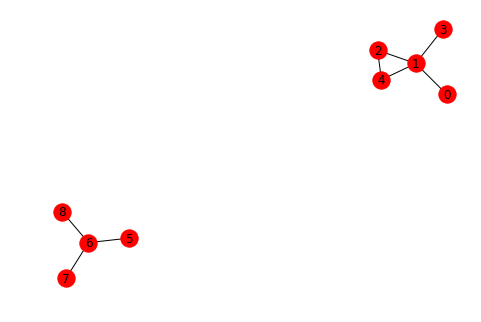

Graph , n_node=9, n_edge=8
Module 0, size=5
Module 1, size=4


{0: array([1, 4, 2, 3, 0]), 1: array([6, 7, 5, 8])}

In [27]:
## a toy test example
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8])
G.add_edges_from([(1,0),(1,2),(1,3),(2,4),(1,4),(5,6),(6,7),(6,8)])
plt.figure()
nx.draw(G,with_labels=True)
plt.show()
mod_analysis(G,min_node=0)

# Computation of the zero probability and the Pearson correlation matrix

In [6]:
## Compute the MI matrix 
p0_ml, p0_dd = sd.dd_zero_prob(data) # marginal zero probability
zero_matrix_ml,zero_matrix_dd = sd.dd_pairwise_zero_prob(data) # pairwise zero probability
mi_ml = sd.zero_to_mi(zero_matrix_ml,up_reg_gene=True) # zero probability to mi matrix 
mi_dd = sd.zero_to_mi(zero_matrix_dd,up_reg_gene=True)

# time start: 0.0s
n_cell=4340, n_gene=2835
# total time: 0.3s
#time start: 0.0s
n_cell=4340, n_gene=2835
# time start: 0.0s
n_cell=4340, n_gene=2835
# total time: 0.2s
# total time: 61.790s


In [27]:
## Compute the PC matrix 
# def preprocess(data):
#     data_ = data.copy()
#     A = data_.X.data
#     cap = np.percentile(A,99)
#     A = A.clip(max=cap)
#     data_.X.data = A
#     return data_

# data_full = preprocess(data)
data_full = data.copy()
size_factor = sd.dd_size_factor(data_full,verbose=False)
mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data_full,size_factor=size_factor)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data_full,size_factor=size_factor)


#time start: 0.0s
n_cell=68579, n_gene=2523, Nr=1246.4
#total: 78.62s
#time start: 0.0s
n_cell=68579, n_gene=2523, Nr=1246.4
2148
#total: 79.70s


In [28]:
cv_dd = np.diag(cov_dd)/mean_dd

In [29]:
gene_list_ = np.array(data.var_names)

In [30]:
gene_list_[np.argsort(cv_dd)[::-1]][:100]

array(['PPBP', 'IGLL5', 'S100A8', 'S100A9', 'GNLY', 'CD74', 'IGJ',
       'PTGDS', 'HLA-DRA', 'NKG7', 'LYZ', 'CST3', 'CCL5', 'GPX1', 'FTL',
       'HLA-DRB1', 'AIF1', 'MALAT1', 'GZMB', 'LST1', 'HLA-DPB1', 'FTH1',
       'HLA-DPA1', 'TYROBP', 'C1QA', 'TCL1A', 'CD79A', 'FCER1A', 'SAT1',
       'FCER1G', 'S100A4', 'GZMH', 'B2M', 'ACTB', 'FGFBP2', 'CLIC3',
       'FCN1', 'CD79B', 'LTB', 'GZMK', 'IL32', 'HLA-DQA1', 'CFD',
       'HLA-DRB5', 'GZMA', 'LGALS1', 'TMSB4X', 'CST7', 'TYMP', 'FCGR3A',
       'S100B', 'IFI30', 'CCL4', 'SERPINA1', 'MS4A7', 'PRF1',
       'RP11-290F20.3', 'OAZ1', 'CYBA', 'PSAP', 'CTSA', 'CTSW', 'MT-CO1',
       'CTSS', 'SPON2', 'TUBA4A', 'ISG15', 'SH3BGRL3', 'FERMT3', 'S100A6',
       'HOPX', 'CPVL', 'HLA-DQA2', 'COTL1', 'TMEM176B', 'JUNB', 'MS4A1',
       'SPI1', 'HLA-DQB1', 'IFITM3', 'RPL13', 'RPLP1', 'TMSB10', 'PFN1',
       'TPM4', 'TAGLN2', 'JUN', 'DUSP2', 'HLA-A', 'CD68', 'HLA-B',
       'RPL34', 'ILK', 'MT-CO2', 'S100A11', 'LIMS1', 'GRAP2', 'CD8B',
       'IER2

In [31]:
cv_ml = np.diag(cov_ml)/mean_ml

In [32]:
gene_list_[np.argsort(cv_ml)[::-1]][:100]

array(['PPBP', 'IGLL5', 'S100A8', 'S100A9', 'GNLY', 'CD74', 'IGJ',
       'PTGDS', 'HLA-DRA', 'NKG7', 'GPX1', 'LYZ', 'CST3', 'CCL5', 'FTL',
       'HLA-DRB1', 'AIF1', 'MALAT1', 'GZMB', 'LST1', 'HLA-DPB1', 'FTH1',
       'TYROBP', 'HLA-DPA1', 'TCL1A', 'CD79A', 'SAT1', 'C1QA', 'S100A4',
       'GZMH', 'FCER1G', 'FCER1A', 'FGFBP2', 'CLIC3', 'B2M', 'FCN1',
       'ACTB', 'CD79B', 'GZMK', 'CFD', 'IL32', 'LTB', 'TYMP', 'HLA-DRB5',
       'HLA-DQA1', 'LGALS1', 'GZMA', 'CST7', 'TMSB4X', 'FCGR3A', 'CCL4',
       'S100B', 'IFI30', 'PRF1', 'PSAP', 'SERPINA1', 'CTSA', 'CYBA',
       'OAZ1', 'TMEM176B', 'SPON2', 'CTSW', 'FERMT3', 'RP11-290F20.3',
       'TUBA4A', 'MT-CO1', 'S100A6', 'ISG15', 'CTSS', 'HOPX', 'SH3BGRL3',
       'MS4A7', 'TPM4', 'SPI1', 'MS4A1', 'HLA-DQA2', 'JUNB', 'ILK',
       'HLA-DQB1', 'COTL1', 'CEBPD', 'TMSB10', 'BLVRB', 'TAGLN2', 'RPL13',
       'RPLP1', 'CPVL', 'IFITM3', 'GRAP2', 'IGFBP7', 'PFN1', 'GSTP1',
       'CD68', 'JUN', 'HLA-A', 'DUSP2', 'LIMS1', 'HLA-B', 'JUND', 'NEAT

In [96]:
def get_PC_dd(cov_dd,mean_dd,PC_prune=1):
    ## clip the variance estimation to be 0: ???
    diag_cov_dd = np.diag(cov_dd)
    
    ## bad indeces
    index_bad = np.zeros([G],dtype=bool)
#     index_bad[diag_cov_dd<=0.1] = True
#     index_bad[(diag_cov_dd/mean_dd)<0.1] = True
        
    print(np.sum(index_bad))
    #plt.figure()
    #plt.hist(diag_cov_dd/mean_dd,bins=np.linspace(0,2,101))
    #plt.show()
    
    np.fill_diagonal(cov_dd,diag_cov_dd.clip(min=1e-12))
        
    ## Pearson correlation
    std_dd = np.sqrt(diag_cov_dd)    
    #std_dd = np.sqrt(diag_cov_dd)
    std_dd = std_dd.reshape([G,1])
    PC_dd = cov_dd/(std_dd.dot(std_dd.T))
    PC_dd = PC_dd.clip(min=-1,max=1)
    
    ## for the bad index, remove the estimation: ???
    if PC_prune:
        PC_dd[:,index_bad] = 0
        PC_dd[index_bad,:] = 0
    return PC_dd

In [101]:
PC_dd = get_PC_dd(cov_dd,mean_dd)

0


In [102]:
N=500
filt_ml = set(gene_list_[np.argsort(cv_ml)[::-1]][:N])
filt_dd = set(gene_list_[np.argsort(cv_dd)[::-1]][:N])

In [103]:
idxx_dd=np.where(np.array([i in filt_dd for i in gene_list_])==1)[0]
PCii_dd=PC_dd[idxx_dd,:][:,idxx_dd]
gene_list_ff = gene_list_[idxx_dd]

In [80]:
nnz_genes=np.where(np.diag(PC_dd)>0)[0]
nnz_genes.shape

(375,)

In [61]:
gene_list= np.array(data.var_names)[nnz_genes]
PCnn_dd=PC_dd[nnz_genes,:][:,nnz_genes]
PCnn_ml=PC_ml[nnz_genes,:][:,nnz_genes]


In [62]:
from sklearn.manifold import SpectralEmbedding

In [63]:
spectral_embeding=SpectralEmbedding(n_components=3, affinity='precomputed')

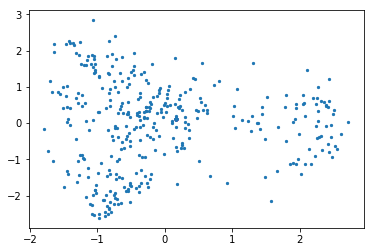

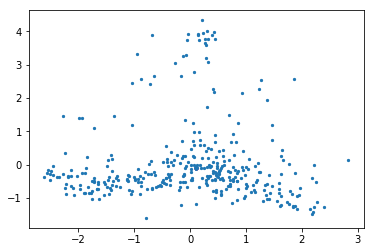

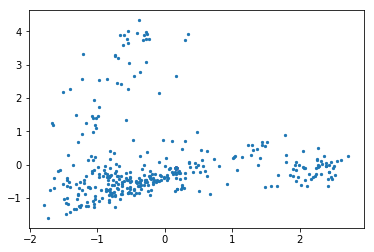

In [64]:
X_se = spectral_embeding.fit_transform(1+PCii_dd)
plt.scatter(X_se[:,0],X_se[:,1],s=5)
plt.show()
plt.scatter(X_se[:,1],X_se[:,2],s=5)
plt.show()
plt.scatter(X_se[:,0],X_se[:,2],s=5)
plt.show()

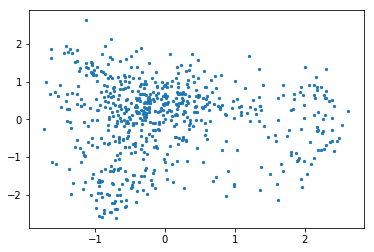

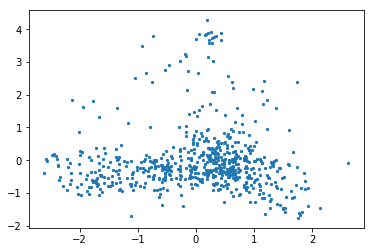

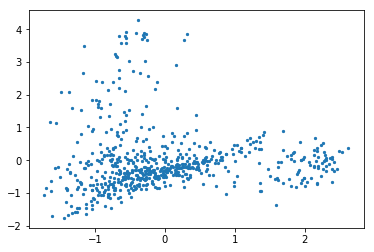

In [65]:
X_se = spectral_embeding.fit_transform(1+PCnn_dd)
plt.scatter(X_se[:,0],X_se[:,1],s=5)
plt.show()
plt.scatter(X_se[:,1],X_se[:,2],s=5)
plt.show()
plt.scatter(X_se[:,0],X_se[:,2],s=5)
plt.show()

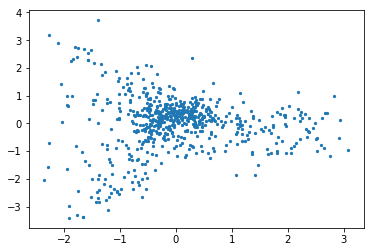

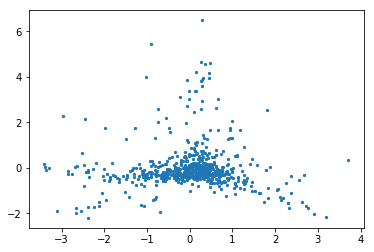

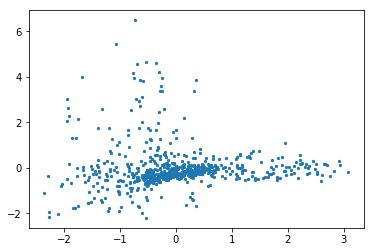

In [66]:
X_se = spectral_embeding.fit_transform(1+PCnn_ml)
plt.scatter(X_se[:,0],X_se[:,1],s=5)
plt.show()
plt.scatter(X_se[:,1],X_se[:,2],s=5)
plt.show()
plt.scatter(X_se[:,0],X_se[:,2],s=5)
plt.show()

In [19]:
comp=10
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se = spectral_embeding.fit_transform(1+PCnn_dd)
for c in range(comp):
    ii=np.argsort(np.abs(X_se[:,c]))[::-1]
    print(c,list(gene_list[ii[:10]]))
    
print()
X_se = spectral_embeding.fit_transform(1+PCnn_ml)
for c in range(comp):
    ii=np.argsort(np.abs(X_se[:,c]))[::-1]
    print(c,list(gene_list[ii[:10]]))

0 ['RPS25', 'RPL32', 'RPL11', 'RPL13', 'RPS2', 'RPL19', 'RPL13A', 'RPS27', 'RPL31', 'RPS6']
1 ['TYMP', 'FTL', 'PSAP', 'CST3', 'B2M', 'PYCARD', 'AIF1', 'LAMTOR4', 'LST1', 'HLA-DRB1']
2 ['RGS10', 'CALM3', 'PKM', 'TUBA4A', 'GPX1', 'TAGLN2', 'OAZ1', 'NAP1L1', 'LAMTOR1', 'PRDX6']
3 ['CD74', 'HLA-DRA', 'HLA-DPA1', 'CD79B', 'CD79A', 'HLA-DQA2', 'HLA-DQA1', 'CD37', 'HLA-DPB1', 'HLA-DRB5']
4 ['GPX1', 'COTL1', 'MT-ND1', 'MT-ND4', 'CD79A', 'MT-ATP6', 'TAGLN2', 'LAMTOR1', 'MT-ND2', 'CD79B']
5 ['IL32', 'PLAC8', 'DUSP1', 'CLIC3', 'S100A10', 'CD7', 'GZMK', 'CD52', 'VIM', 'FOS']
6 ['MT-CO2', 'MT-ND2', 'MT-ND4', 'MT-CYB', 'MT-ATP6', 'RPL21', 'FCER1G', 'CD52', 'FCGR3A', 'RPL7']
7 ['CD52', 'RPLP0', 'MALAT1', 'TMSB10', 'CD3D', 'FOS', 'RPS27', 'DUSP1', 'ZFP36', 'RPSA']
8 ['RPL7', 'RPL26', 'BTG1', 'MT-ND2', 'RPL34', 'MT-ATP6', 'RPS24', 'RPS3A', 'H3F3B', 'MT-CO2']
9 ['GZMH', 'MT-CO2', 'MT-ATP6', 'CD8A', 'MT-ND4', 'CCL5', 'MT-ND2', 'MT-CYB', 'MT-CO3', 'RPS3']

0 ['RPL13', 'RPL32', 'RPS6', 'RPS2', 'RPL3', 'RPL

In [68]:
gene='CD79A'

X=PCnn_dd
loc = np.where(gene_list==gene)[0][0]
ii=np.argsort(X[loc])[::-1]
print('dd:',list(gene_list[ii[:10]]))

X=PCnn_ml
loc = np.where(gene_list==gene)[0][0]
ii=np.argsort(X[loc])[::-1]
print('ml:',list(gene_list[ii[:10]]))

dd: ['CD79A', 'CD79B', 'MS4A1', 'CD74', 'CD37', 'TCL1A', 'HLA-DRA', 'HLA-DQA2', 'HLA-DMB', 'HLA-DPA1']
ml: ['CD79A', 'CD74', 'CD79B', 'HLA-DRA', 'TCL1A', 'MS4A1', 'CD37', 'HLA-DPA1', 'HLA-DRB1', 'HLA-DPB1']


In [69]:
gene2='TNFRSF13C'
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

IndexError: index 0 is out of bounds for axis 0 with size 0

dd: 0.9310991506999237
ml: 0.6820570764997458


Text(0,0.5,'CD79B')

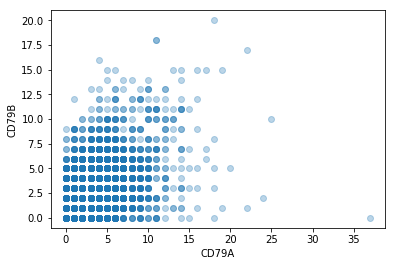

In [45]:
gene2='CD79B'
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

In [20]:
X=1+PCnn_ml #affinity
comp=3
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se = spectral_embeding.fit_transform(X)

IndexError: index 0 is out of bounds for axis 0 with size 0

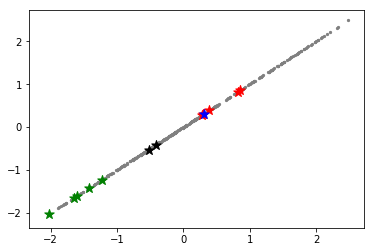

In [21]:
dim1,dim2=0,1
for dim1 in range(comp):
    for dim2 in range(dim1,comp):
        plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')

        idx=[]
        for g in marker_gene_dic['T-cells']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

        idx=[]
        for g in marker_gene_dic['NK-cells']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

        idx=[]
        for g in marker_gene_dic['B-cells']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

        
        idx=[]
        for g in marker_gene_dic['Innate Immunity']+marker_gene_dic['myeloid']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

        idx=[]
        for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
       'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
       'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
       'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
       'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')
        plt.title(str([dim1,dim2]))
        plt.show()

In [70]:
X=1+PCnn_dd #affinity
comp=3
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se = spectral_embeding.fit_transform(X)

IndexError: index 0 is out of bounds for axis 0 with size 0

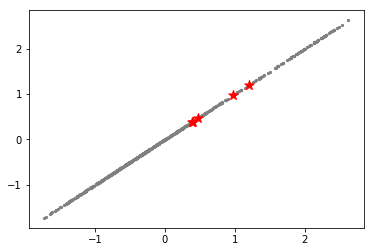

In [71]:
dim1,dim2=0,1
for dim1 in range(comp):
    for dim2 in range(dim1,comp):
        plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')

        idx=[]
        for g in marker_gene_dic['T-cells']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

        idx=[]
        for g in marker_gene_dic['NK-cells']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

        idx=[]
        for g in marker_gene_dic['B-cells']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

        idx=[]
        for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

        idx=[]
        for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
       'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
       'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
       'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
       'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
            if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
        plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')
        plt.title(str([dim1,dim2]))
        plt.show()

In [23]:
X=1+PCnn_dd #affinity
comp=2
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se_dd = spectral_embeding.fit_transform(X)

In [24]:
X=1+PCnn_ml #affinity
comp=2
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se_ml = spectral_embeding.fit_transform(X)

In [223]:
pt=np.array(4*(np.random.rand(2)-0.5))

idx_pt=np.argsort([np.linalg.norm(X_se_dd[i,:] - pt) for i in range(X_se_dd.shape[0])])[:10]
lista=[i for i in gene_list[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_se_dd[:,dim1],X_se_dd[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_se_dd[idx_pt,dim1],X_se_dd[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

plt.scatter(X_se_ml[:,dim1],X_se_ml[:,dim2],s=5,c='gray')
idx=[]
for g in lista:
            if g in gene_list:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se_ml[idx,dim1],X_se_ml[idx,dim2],s=100,marker='*',c='r')
plt.show()

NameError: name 'X_se_dd' is not defined

In [224]:
pt=np.array(5*(np.random.rand(2)-0.5))

idx_pt=np.argsort([np.linalg.norm(X_se_ml[i,:] - pt) for i in range(X_se_ml.shape[0])])[:10]
lista=[i for i in gene_list[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_se_ml[:,dim1],X_se_ml[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_se_ml[idx_pt,dim1],X_se_ml[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

plt.scatter(X_se_dd[:,dim1],X_se_dd[:,dim2],s=5,c='gray')
idx=[]
for g in lista:
            if g in gene_list:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se_dd[idx,dim1],X_se_dd[idx,dim2],s=100,marker='*',c='r')
plt.show()

NameError: name 'X_se_ml' is not defined

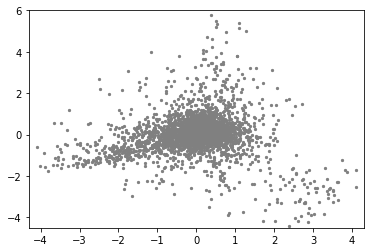

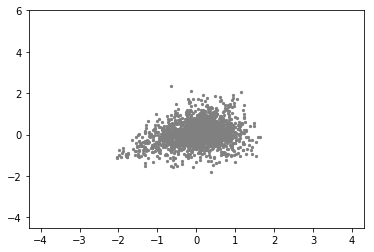

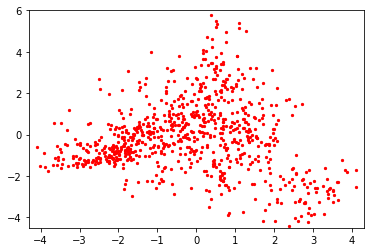

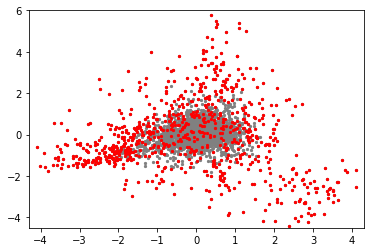

In [53]:
X=1+PC_ml #affinity
comp=2
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se = spectral_embeding.fit_transform(X)

dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')
plt.xlim([-4.3,4.3])
plt.ylim([-4.5,6])
plt.show()

z_genes=np.array([i  for i in range(X_se.shape[0]) if i not in nnz_genes])
plt.scatter(X_se[z_genes,dim1],X_se[z_genes,dim2],s=5,c='gray')
plt.xlim([-4.3,4.3])
plt.ylim([-4.5,6])
plt.show()

plt.scatter(X_se[nnz_genes,dim1],X_se[nnz_genes,dim2],s=5,c='r')
plt.xlim([-4.3,4.3])
plt.ylim([-4.5,6])
plt.show()


plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')
plt.scatter(X_se[nnz_genes,dim1],X_se[nnz_genes,dim2],s=5,c='r')
plt.xlim([-4.3,4.3])
plt.ylim([-4.5,6])
plt.show()

In [28]:

k=20

X=PCnn_dd

adj_KNN_dd=np.zeros_like(X)


for gene in gene_list:
    loc = np.where(gene_list==gene)[0][0]
    ii=np.argsort(X[loc])[::-1]
    for i in ii[1:k+1]:
        adj_KNN_dd[loc,i] = 1
        adj_KNN_dd[i,loc] = 1
#     print('dd:',list(gene_list[ii[:k]]))

X=PCnn_ml

adj_KNN_ml=np.zeros_like(X)


for gene in gene_list:
    loc = np.where(gene_list==gene)[0][0]
    ii=np.argsort(X[loc])[::-1]
    for i in ii[1:k+1]:
        adj_KNN_ml[loc,i] = 1
        adj_KNN_ml[i,loc] = 1
#     print('dd:',list(gene_list[ii[:k]]))

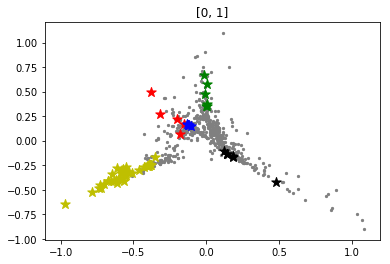

In [29]:
X=adj_KNN_dd #affinity
comp=3
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se = spectral_embeding.fit_transform(X)

dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')



idx=[]
for g in marker_gene_dic['T-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

idx=[]
for g in marker_gene_dic['NK-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

idx=[]
for g in marker_gene_dic['B-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

idx=[]
for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

idx=[]
for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')
plt.title(str([dim1,dim2]))
plt.show()

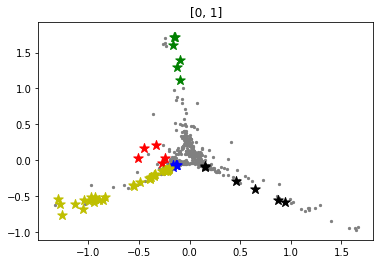

In [30]:
X=adj_KNN_ml #affinity
comp=3
spectral_embeding=SpectralEmbedding(n_components=comp, affinity='precomputed')
X_se = spectral_embeding.fit_transform(X)

dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')



idx=[]
for g in marker_gene_dic['T-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

idx=[]
for g in marker_gene_dic['NK-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

idx=[]
for g in marker_gene_dic['B-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

idx=[]
for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

idx=[]
for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')
plt.title(str([dim1,dim2]))
plt.show()

In [31]:
import seaborn as sns

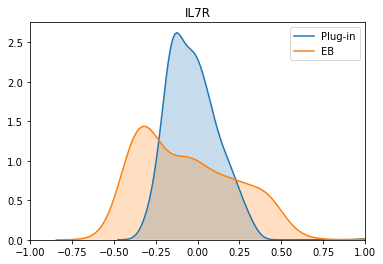

dd(+): ['TMEM123', 'SPOCK2', 'TRAT1', 'RPL14', 'AAK1']
dd(-): ['POMP', 'RHOA', 'LY86', 'COX8A', 'ARPC3']
ml(+): ['RPS3', 'IL32', 'RPS29', 'EEF1A1', 'RPL3']
ml(-): ['HLA-DRA', 'HLA-DRB1', 'TYROBP', 'CD74', 'HLA-DQB1']





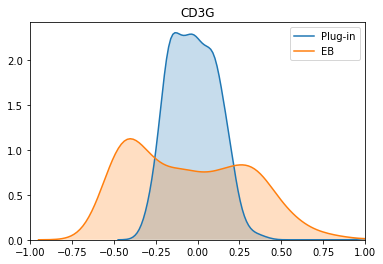

dd(+): ['LCK', 'CD3D', 'CD3E', 'LAT', 'CDC42SE2']
dd(-): ['LY86', 'POMP', 'RHOA', 'GNG5', 'CNPY3']
ml(+): ['CD3D', 'TRAC', 'CD3E', 'IL32', 'LCK']
ml(-): ['HLA-DRA', 'TYROBP', 'FCER1G', 'CD74', 'HLA-DRB1']





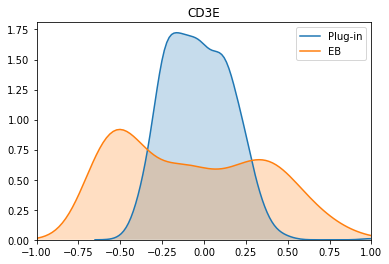

dd(+): ['LCK', 'CD3D', 'LAT', 'ACAP1', 'AAK1']
dd(-): ['LY86', 'MARCH1', 'GNG5', 'POMP', 'HLA-DMA']
ml(+): ['CD3D', 'TRAC', 'IL32', 'RPS29', 'RPS3']
ml(-): ['HLA-DRA', 'HLA-DRB1', 'CD74', 'TYROBP', 'HLA-DQB1']





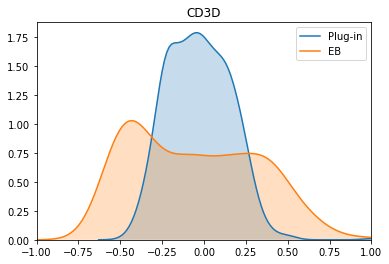

dd(+): ['LCK', 'CD3E', 'CD3G', 'LAT', 'CD27']
dd(-): ['LY86', 'SERP1', 'MARCH1', 'ATP6V0B', 'CTSH']
ml(+): ['TRAC', 'CD3E', 'IL32', 'LCK', 'CD3G']
ml(-): ['HLA-DRA', 'TYROBP', 'CD74', 'HLA-DRB1', 'FTL']





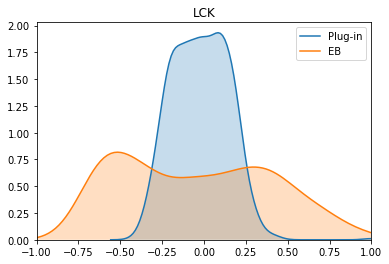

dd(+): ['ACAP1', 'HMHA1', 'CD3D', 'CD3E', 'LAT']
dd(-): ['LY86', 'CTSH', 'MARCH1', 'ATP6V0B', 'HLA-DMA']
ml(+): ['CD3D', 'IL32', 'TRAC', 'CD3E', 'HLA-A']
ml(-): ['HLA-DRA', 'FTL', 'HLA-DRB1', 'CD74', 'CTSS']





In [32]:
for gene in marker_gene_dic['T-cells']:
    loc = np.where(gene_list==gene)[0][0]
    
    

    sns.distplot(PCnn_ml[loc,:],label='Plug-in',hist=0,kde_kws={'shade':1})
    sns.distplot(PCnn_dd[loc,:],label='EB',hist=0,kde_kws={'shade':1})
    plt.xlim([-1,1])
    plt.title(gene)
    plt.legend()
    plt.show()
    
    ii=np.argsort(PCnn_dd[loc])[::-1]
    print('dd(+):',list(gene_list[ii[1:6]]))
    print('dd(-):',list(gene_list[ii[::-1][:5]]))
    
    ii=np.argsort(PCnn_ml[loc])[::-1]
    print('ml(+):',list(gene_list[ii[1:6]]))
    print('ml(-):',list(gene_list[ii[::-1][:5]]))
    print('\n\n')



In [33]:
gene='LCK'
loc = np.where(gene_list==gene)[0][0]

k=10

ii=np.argsort(PCnn_ml[loc])[::-1]
print('ml(+):',list(gene_list[ii[1:k+1]]),str(PCnn_ml[loc,ii[k+1]])[:4])
ii=np.argsort(PCnn_dd[loc])[::-1]
print('dd(+):',list(gene_list[ii[1:k+1]]),str(PCnn_dd[loc,ii[k+1]])[:4])

print()

ii=np.argsort(PCnn_ml[loc])
print('ml(-):',list(gene_list[ii[:k]]),str(PCnn_ml[loc,ii[0]])[:4])
ii=np.argsort(PCnn_dd[loc])
print('dd(-):',list(gene_list[ii[:k]]),str(PCnn_dd[loc,ii[0]])[:4])



ml(+): ['CD3D', 'IL32', 'TRAC', 'CD3E', 'HLA-A', 'B2M', 'TRBC2', 'HLA-B', 'CD3G', 'MALAT1'] 0.30
dd(+): ['ACAP1', 'HMHA1', 'CD3D', 'CD3E', 'LAT', 'EVL', 'AAK1', 'GYPC', 'CD27', 'ARHGEF1'] 0.85

ml(-): ['HLA-DRA', 'FTL', 'HLA-DRB1', 'CD74', 'CTSS', 'LYZ', 'CST3', 'TYROBP', 'HLA-DQB1', 'FTH1'] -0.4
dd(-): ['LY86', 'CTSH', 'MARCH1', 'ATP6V0B', 'HLA-DMA', 'CTSZ', 'HLA-DRA', 'SPI1', 'APLP2', 'LYN'] -0.8


dd: 0.9984748362110447
ml: 0.1864806648848817


Text(0,0.5,'HMHA1')

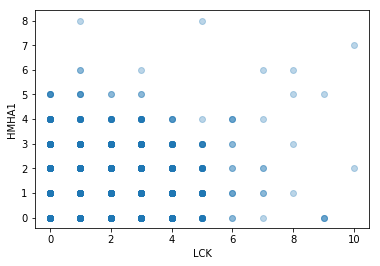

In [34]:
# gene='LCK'
# gene2='ACAP1'
gene='LCK'
gene2='HMHA1'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: 1.0
ml: 0.1380709243836071


Text(0,0.5,'MYL12B')

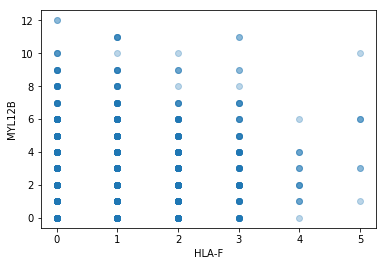

In [35]:
# gene='LCK'
# gene2='ACAP1'
gene='HLA-F'
gene2='MYL12B'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: 0.8876764002527705
ml: 0.30781729586334655


Text(0,0.5,'HLA-F')

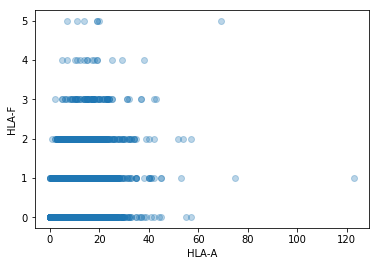

In [36]:
# gene='LCK'
# gene2='ACAP1'
gene='HLA-A'
gene2='HLA-F'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: 1.0
ml: 0.263000468523768


Text(0,0.5,'ACAP1')

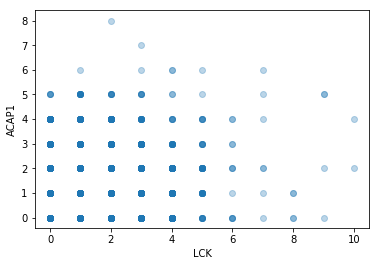

In [37]:
gene='LCK'
gene2='ACAP1'

loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

dd: -0.7290418907853978
ml: -0.33257330227091725


Text(0,0.5,'LY86')

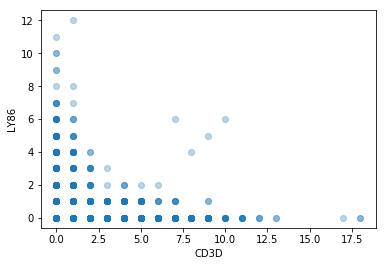

In [78]:
# gene='LCK'
# gene2='ACAP1'
gene='CD3D'
gene2='LY86'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

In [38]:
PCnn_diff = np.abs(PCnn_dd - PCnn_ml)

In [42]:
np.sum(PCnn_diff>0.9)

48

PCBP1 ATP5D
dd: 1.0
ml: 0.07800947987348046


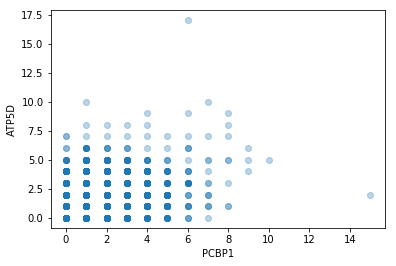

PCBP1 ST13
dd: -1.0
ml: -0.09615493255404677


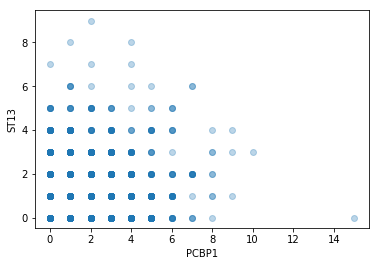

COX5B RPS26
dd: 1.0
ml: 0.08567857420276559


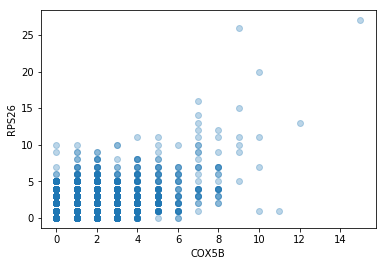

NBEAL1 EIF3F
dd: 1.0
ml: 0.07692071518392407


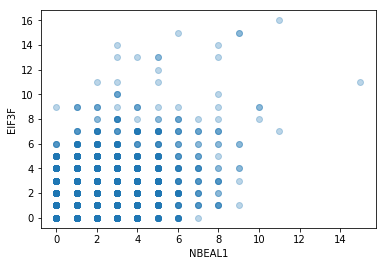

ARPC4 USMG5
dd: 1.0
ml: 0.09946745779967883


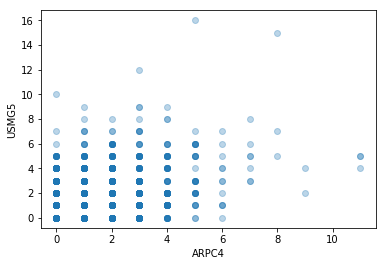

PNISR ATP5L
dd: -0.9953350821153757
ml: -0.09275361010601677


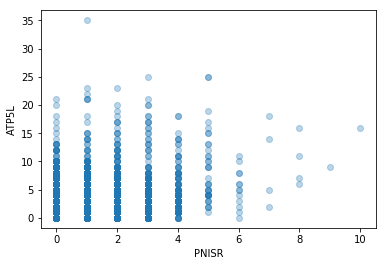

COX7B PSMA7
dd: 1.0
ml: 0.09987084765047291


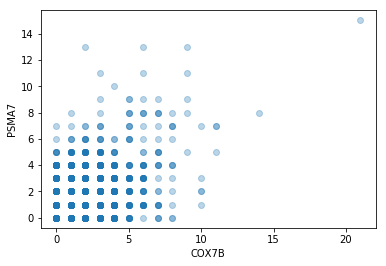

COX7B ATP5D
dd: 1.0
ml: 0.09549671360273669


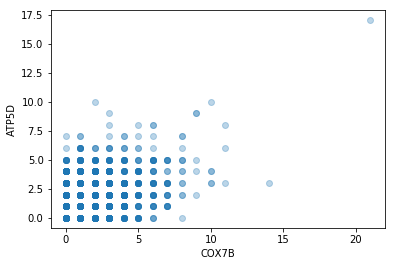

PGK1 ATP5L
dd: 1.0
ml: 0.08588826573824028


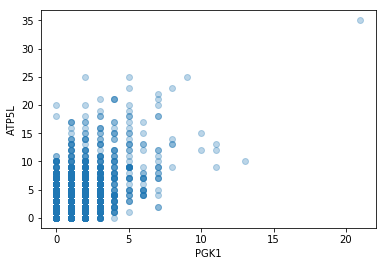

EIF3F POMP
dd: -1.0
ml: -0.08809024307348709


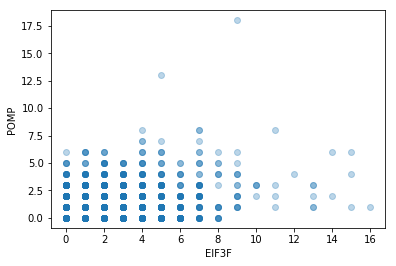

EIF3F CKLF
dd: -1.0
ml: -0.09100926885952375


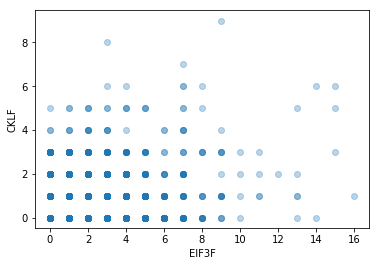

EIF3F COX6B1
dd: -1.0
ml: -0.07371410295935238


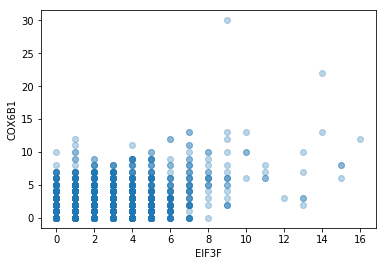

ATP5L RPS26
dd: 1.0
ml: 0.08150302743571988


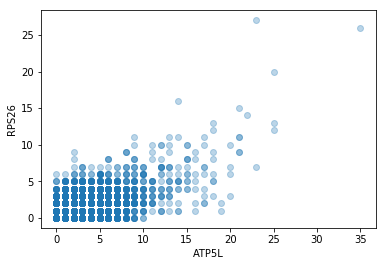

ATP5L POMP
dd: 1.0
ml: 0.08760170359131572


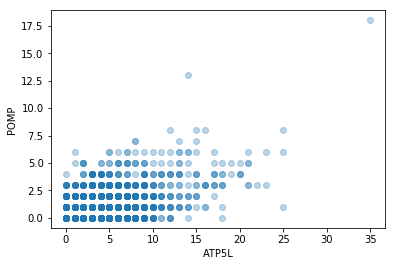

ATP5L VAMP2
dd: -0.9783783749895486
ml: -0.07818169674964882


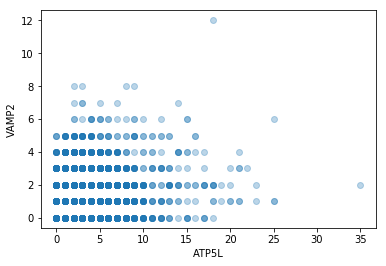

ATP5L CIRBP
dd: -1.0
ml: -0.08476197359807167


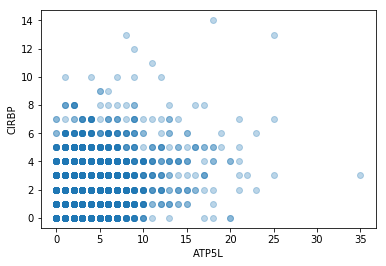

DAZAP2 ATP5D
dd: 0.9925361489008283
ml: 0.08210895054202773


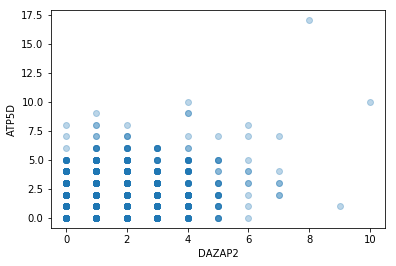

RPS26 POMP
dd: 1.0
ml: 0.0903934444845801


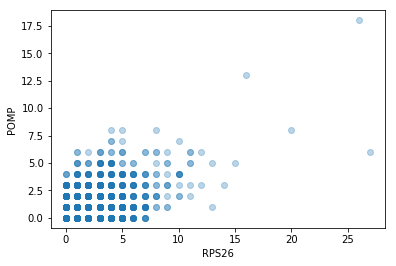

POMP PSMA7
dd: 1.0
ml: 0.09967365365763538


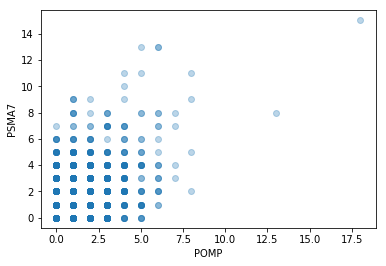

N4BP2L2 COX4I1
dd: -0.9947323800205061
ml: -0.06225155156215992


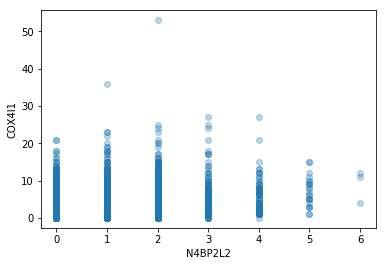

COX4I1 UBA52
dd: 1.0
ml: 0.09062072525408015


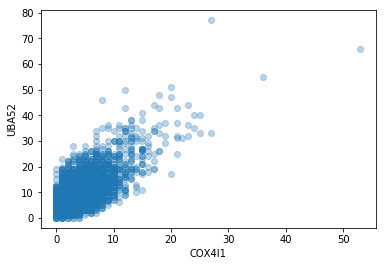

COX4I1 EIF3K
dd: 1.0
ml: 0.06277423747171061


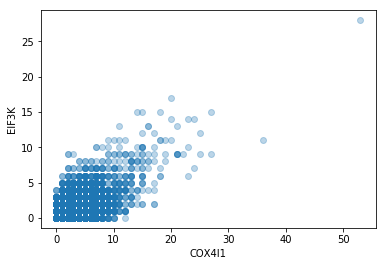

PSMA7 COX6B1
dd: 1.0
ml: 0.09400579574642226


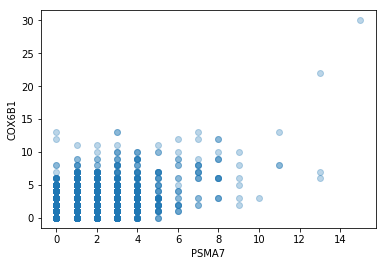

HMHA1 ATP5D
dd: -1.0
ml: -0.08851461667408478


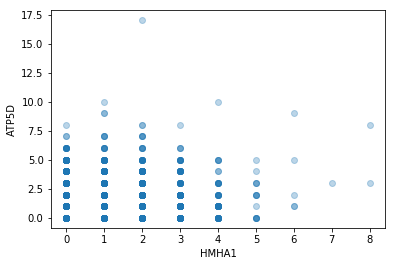

In [43]:
for i in range(len(gene_list)):
    for j in range(i+1,len(gene_list)):
        if PCnn_diff[i,j]>0.9:
            gene = gene_list[i]
            gene2 = gene_list[j]
            print(gene,gene2)
            print('dd:',PCnn_dd[i,j])
            print('ml:',PCnn_ml[i,j])

            x1 = np.array(data_full[:,gene].X)
            x2 = np.array(data_full[:,gene2].X)
            plt.scatter(x1,x2,alpha=0.3)
            plt.xlabel(gene)
            plt.ylabel(gene2)
            plt.show()
            
            

# ???

dd: 0.5452897309647541
ml: 0.07855854653663877


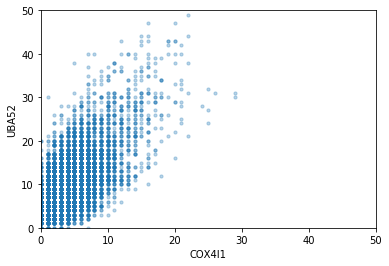

In [54]:
gene='COX4I1' 
gene2='UBA52'

loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3,s=10)
plt.xlabel(gene)
plt.ylabel(gene2)

plt.xlim([0,50])
plt.ylim([0,50])
plt.show()

In [67]:
lst1=[]
lst2=[]

for i in range(len(gene_list)):
    for j in range(i+1,len(gene_list)):
        if PCnn_diff[i,j]>0.7:
            gene = gene_list[i]
            gene2 = gene_list[j]
            lst1+=[gene]
            lst2+=[gene2]
#             print((gene,gene2))
#             print('dd:',PCnn_dd[i,j])
#             print('ml:',PCnn_ml[i,j],'\n')





#             x1 = np.array(data_full[:,gene].X)
#             x2 = np.array(data_full[:,gene2].X)
#             plt.scatter(x1,x2,alpha=0.3)
#             plt.xlabel(gene)
#             plt.ylabel(gene2)
#             plt.show()
            
            

In [68]:
print(np.unique(lst1+lst2))

['AAK1' 'ABHD17A' 'ABI3' 'ABRACL' 'AC090498.1' 'ACAP1' 'ACTR2' 'AHNAK'
 'ALDOA' 'ANXA5' 'ANXA6' 'AP1S2' 'AP2S1' 'APLP2' 'APMAP' 'APOBEC3G'
 'ARHGDIB' 'ARHGEF1' 'ARL6IP5' 'ARPC1B' 'ARPC2' 'ARPC3' 'ARPC4' 'ARPC5'
 'ARPC5L' 'ASAH1' 'ATG3' 'ATP5B' 'ATP5D' 'ATP5E' 'ATP5G2' 'ATP5I' 'ATP5L'
 'ATP5O' 'ATP6V0B' 'ATP6V0E1' 'BIN2' 'BLOC1S1' 'BLVRB' 'BRI3' 'C10orf54'
 'C12orf75' 'C14orf2' 'C4orf48' 'C6orf48' 'CALM2' 'CAP1' 'CAPZA1' 'CAPZB'
 'CARD16' 'CASP1' 'CD302' 'CD53' 'CD99' 'CDA' 'CDC42SE1' 'CDC42SE2' 'CFL1'
 'CFP' 'CHP1' 'CHST12' 'CIRBP' 'CKLF' 'CLEC12A' 'CLEC4A' 'CLEC7A' 'CLIC1'
 'CMTM6' 'CNPY3' 'CORO1A' 'COX4I1' 'COX5B' 'COX6B1' 'COX7B' 'COX8A'
 'CPPED1' 'CSF3R' 'CSTA' 'CSTB' 'CTSB' 'CTSC' 'CTSD' 'CTSS' 'CTSZ' 'CYBA'
 'CYBB' 'DAZAP2' 'DBI' 'DOK2' 'DRAP1' 'DYNLL1' 'EEF1B2' 'EEF2' 'EIF3F'
 'EIF3K' 'EIF3L' 'EIF4A2' 'EIF5A' 'EMP3' 'ENO1' 'ENY2' 'ETS1' 'EVL' 'FAU'
 'FCER1G' 'FCMR' 'FERMT3' 'FGL2' 'FGR' 'FKBP1A' 'FLNA' 'FLT3LG' 'FYN'
 'GAPDH' 'GCA' 'GLIPR1' 'GLRX' 'GLTSCR2' 'GMFG' 'GNAI2' 'GNB2L

In [55]:
gene='FCER1G'
for i in np.where(np.array(lst1)==gene)[0]:
    gene2=lst2[i]
    loc = np.where(gene_list==gene)[0][0]
    loc2 = np.where(gene_list==gene2)[0][0]
    print((gene,gene2))
    print('dd:',PCnn_dd[loc,loc2])
    print('ml:',PCnn_ml[loc,loc2],'\n')





    x1 = np.array(data_full[:,gene].X)
    x2 = np.array(data_full[:,gene2].X)
    plt.scatter(x1,x2,alpha=0.3)
    plt.xlabel(gene)
    plt.ylabel(gene2)
    plt.show()
    
for i in np.where(np.array(lst2)==gene)[0]:
    gene2=lst1[i]
    loc = np.where(gene_list==gene)[0][0]
    loc2 = np.where(gene_list==gene2)[0][0]
    print((gene,gene2))
    print('dd:',PCnn_dd[loc,loc2])
    print('ml:',PCnn_ml[loc,loc2],'\n')





    x1 = np.array(data_full[:,gene].X)
    x2 = np.array(data_full[:,gene2].X)
    plt.scatter(x1,x2,alpha=0.3)
    plt.xlabel(gene)
    plt.ylabel(gene2)
    plt.show()
    

NameError: name 'lst1' is not defined

In [81]:
gene='CD14'
loc = np.where(gene_list==gene)[0][0]

loc_f = np.where(gene_list_ff==gene)[0][0]
k=10

ii=np.argsort(PCnn_ml[loc])[::-1]
print('ml(+):',list(gene_list[ii[1:k+1]]),str(PCnn_ml[loc,ii[k+1]])[:4])
ii=np.argsort(PCnn_dd[loc])[::-1]
print('dd(+):',list(gene_list[ii[1:k+1]]),str(PCnn_dd[loc,ii[k+1]])[:4])
ii=np.argsort(PCii_dd[loc_f])[::-1]
print('ff(+):',list(gene_list_ff[ii[1:k+1]]),str(PCii_dd[loc_f,ii[k+1]])[:4])

print()

ii=np.argsort(PCnn_ml[loc])
print('ml(-):',list(gene_list[ii[:k]]),str(PCnn_ml[loc,ii[0]])[:4])
ii=np.argsort(PCnn_dd[loc])
print('dd(-):',list(gene_list[ii[:k]]),str(PCnn_dd[loc,ii[0]])[:4])
ii=np.argsort(PCii_dd[loc_f])
print('ff(-):',list(gene_list_ff[ii[:k]]),str(PCii_dd[loc_f,ii[0]])[:4])



IndexError: index 0 is out of bounds for axis 0 with size 0

dd: -0.6311411180109736
ml: -0.3064353994388179


Text(0,0.5,'EVL')

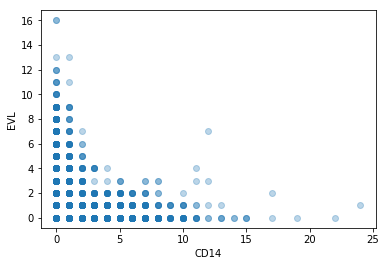

In [58]:
gene='CD14'
gene2='EVL'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

In [22]:
from sklearn.manifold import TSNE


In [23]:
tsne=TSNE(n_components=2,metric='precomputed')



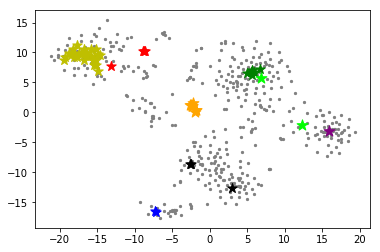

In [105]:
# X_tsne=tsne.fit_transform(1-PCii_dd)
X_se=X_tsne

dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')



idx=[]
for g in marker_gene_dic['T-cells']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

idx=[]
for g in marker_gene_dic['NK-cells']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

idx=[]
for g in marker_gene_dic['B-cells']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

idx=[]
for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

idx=[]
for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')

idx=[]
for g in ['PPBP','RGS18']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='purple')

idx=[]
for g in gene_list_ff:
    if g.startswith('MT-'): idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='orange')



idx=[]
for g in ['CCDC50']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='m')

idx=[]
for g in ['TMSB4X','CD63']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='lime')

# idx=[]
# for g in ['FCGR3A', 'MS4A7']:
#     if g in data_full.var_names:idx += [np.where(gene_list_ff==g)[0][0]]
# plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='cyan')



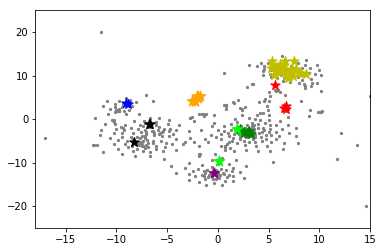

In [100]:
X_tsne=tsne.fit_transform(1-PCii_dd)
X_se=X_tsne

dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')
plt.xlim([-18,15])
plt.ylim([-25,25])


idx=[]
for g in marker_gene_dic['T-cells']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

idx=[]
for g in marker_gene_dic['NK-cells']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

idx=[]
for g in marker_gene_dic['B-cells']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

idx=[]
for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

idx=[]
for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')

idx=[]
for g in ['PPBP','RGS18']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='purple')

idx=[]
for g in gene_list_ff:
    if g.startswith('MT-'): idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='orange')



idx=[]
for g in ['CCDC50']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='m')

idx=[]
for g in ['TMSB4X','CD63']:
    if g in gene_list_ff:idx += [np.where(gene_list_ff==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='lime')

# idx=[]
# for g in ['FCGR3A', 'MS4A7']:
#     if g in data_full.var_names:idx += [np.where(gene_list_ff==g)[0][0]]
# plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='cyan')



['CCL5', 'HLA-B', 'HLA-C', 'GZMA', 'HLA-A', 'CST7', 'GZMH', 'CTSW', 'CD63', 'NKG7', 'GNLY', 'CD99', 'HCST', 'HOPX', 'B2M']


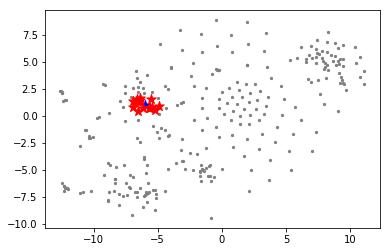

In [84]:
pt=np.array([-6,1])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:15]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['RPS4X', 'RPL3', 'RPL4', 'RPS6', 'EEF1A1', 'RPL5', 'RPS3', 'RPL10', 'RPL10A', 'RPS25']


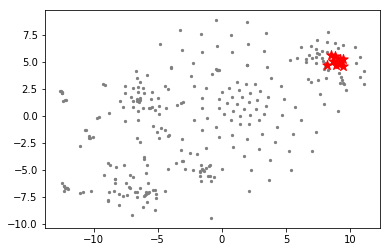

['FCN1', 'TYMP', 'PSAP', 'FTL', 'NEAT1', 'PYCARD', 'CFD', 'TYROBP', 'S100A11', 'AIF1', 'LAMTOR4', 'LST1', 'SPI1', 'CEBPD', 'IFITM3', 'IFI30', 'CTSS', 'GSTP1', 'SERPINA1', 'TSPO']


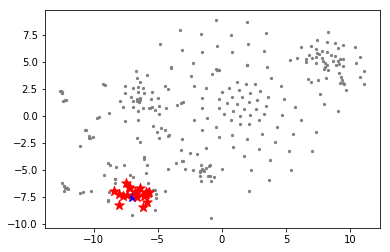

['OAZ1', 'GPX1', 'TAGLN2', 'TPM4', 'PPBP', 'LAMTOR1', 'CTSA', 'CDKN2D', 'FERMT3', 'ARPC1B', 'LIMS1', 'CALM3', 'PRDX6', 'PKM', 'TUBA4A', 'TMSB4X', 'SH3BGRL3', 'RGS10', 'DYNLL1', 'GSTO1']


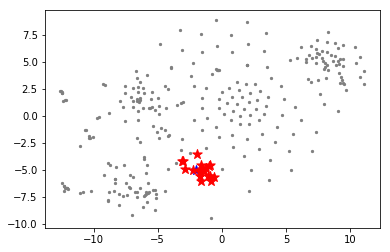

In [87]:
pt=np.array([9,5])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:10]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

pt=np.array([-7,-7.5])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:20]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

pt=np.array([-2,-5])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:20]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['RP11-291B21.2', 'CD8B', 'CD8A']


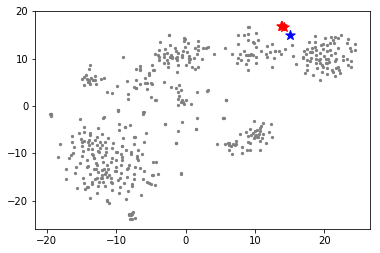

In [191]:
pt=np.array([15,15])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:3]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['CD37', 'CD22', 'CD79A', 'TNFRSF13C', 'HVCN1', 'EAF2', 'CD79B', 'IGHD', 'BANK1', 'MS4A1', 'LINC00926', 'FCER2', 'IGKC', 'ORAI2', 'IGHM', 'TCL1A', 'CYB561A3', 'PLPP5', 'VPREB3', 'MEF2C']


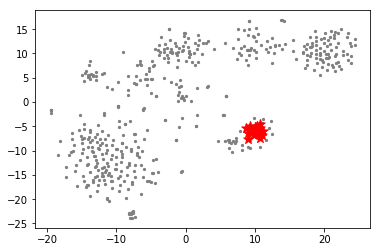

In [194]:
pt=np.array([10,-6])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:20]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['LY86', 'PHACTR1', 'POU2F2', 'HLA-DMA', 'HLA-DRA', 'FAM26F', 'HLA-DRB1', 'HLA-DMB', 'HLA-DQB1', 'MARCH1']


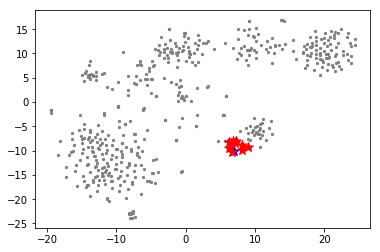

In [189]:
pt=np.array([7,-10])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:10]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['ALOX5AP', 'SEC61B', 'IRF7', 'GZMB', 'CCDC50', 'IRF8', 'PLD4', 'ITM2C', 'PLAC8', 'JCHAIN', 'C12orf75', 'MZB1', 'CTSC', 'RGS1', 'GPR183']


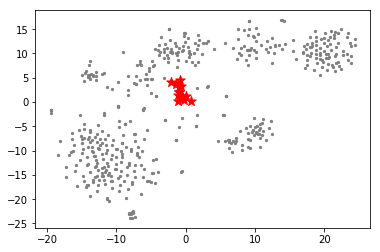

In [183]:
pt=np.array([-1,2])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:15]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['LSP1', 'ARPC1B', 'ACTB', 'TUBA1B', 'ARPC2', 'MYL6', 'PFN1', 'CFL1', 'ACTG1', 'CORO1A', 'TMSB4X', 'MARCKSL1', 'TXN', 'EMP3', 'TMSB10', 'CLIC1', 'RP5-1171I10.5', 'CD63', 'PLEK', 'ITGB2', 'SH3BGRL3', 'CTSC', 'LY6E', 'ISG15', 'ABI3']


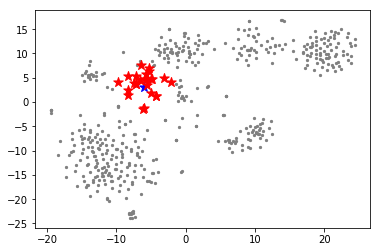

In [186]:
pt=np.array([-6,3])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:25]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

['MT-ND2', 'MT-CYB', 'MT-ND1', 'MT-ND3', 'MT-ATP6', 'MT-ND5', 'MT-ND4', 'MT-CO3', 'MT-CO2', 'MT-CO1', 'TMEM107', 'CH17-373J23.1', 'RP11-160E2.6', 'MT-ND4L', 'KLF10']


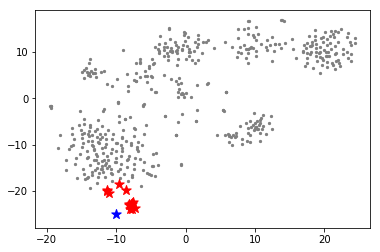

In [195]:
pt=np.array([-10,-25])
idx_pt=np.argsort([np.linalg.norm(X_tsne[i,:] - pt) for i in range(X_tsne.shape[0])])[:15]
lista=[i for i in gene_list_ff[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne[:,dim1],X_tsne[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne[idx_pt,dim1],X_tsne[idx_pt,dim2],s=100,marker='*',c='r')
plt.show()

In [226]:
for i in ['GSTO1', 'ITM2B', 'RGS18', 'YWHAH', 'FLNA', 'CTSA', 'NCOA4', 'TXNIP', 'TLN1', 'LIMS1', 'TPM4', 'FERMT3', 'PPBP', 'ODC1', 'RAP1B', 'TUBA4A', 'MYL12A', 'RGS10', 'TAGLN2', 'ITGB1']:
    print(i)

GSTO1
ITM2B
RGS18
YWHAH
FLNA
CTSA
NCOA4
TXNIP
TLN1
LIMS1
TPM4
FERMT3
PPBP
ODC1
RAP1B
TUBA4A
MYL12A
RGS10
TAGLN2
ITGB1


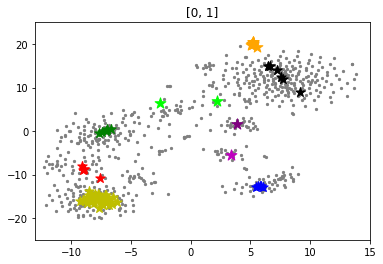

In [78]:
# X_tsne_ml=tsne.fit_transform(1-PCnn_ml)
X_se=X_tsne_ml


dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')



idx=[]
for g in marker_gene_dic['T-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

idx=[]
for g in marker_gene_dic['NK-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

idx=[]
for g in marker_gene_dic['B-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

idx=[]
for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

idx=[]
for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')

idx=[]
for g in ['PPBP','RGS18']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='purple')

idx=[]
for g in gene_list_ff:
    if g.startswith('MT-'): idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='orange')


idx=[]
for g in ['CCDC50']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='m')

idx=[]
for g in ['TMSB4X','CD63']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='lime')

plt.xlim([-13,15])
plt.ylim([-25,25])
plt.title(str([dim1,dim2]))
plt.show()

['IFRD1', 'RASGRP2', 'CCNG1', 'KIF2A', 'NT5C3A', 'SNAP23', 'EIF4G2', 'OST4', 'GRAP2', 'PTMA', 'ODC1', 'MAX', 'RAP1B', 'CALM3', 'TUBA4A', 'LIMS1', 'RGS10', 'CDKN2D', 'YWHAH', 'RGS18', 'FERMT3', 'CARD19', 'TPM4', 'RGCC', 'FAM110A']


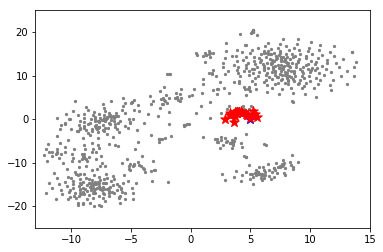

In [75]:
pt=np.array([5,-0])
idx_pt=np.argsort([np.linalg.norm(X_tsne_ml[i,:] - pt) for i in range(X_tsne_ml.shape[0])])[:25]
lista=[i for i in gene_list[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne_ml[:,dim1],X_tsne_ml[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne_ml[idx_pt,dim1],X_tsne_ml[idx_pt,dim2],s=100,marker='*',c='r')
plt.xlim([-13,15])
plt.ylim([-25,25])
plt.show()

In [ ]:
['ALOX5AP', 'SEC61B', 'IRF7', 'GZMB', 'CCDC50', 'IRF8', 'PLD4', 'ITM2C', 'PLAC8', 'JCHAIN', 'C12orf75', 'MZB1', 'CTSC', 'RGS1', 'GPR183']

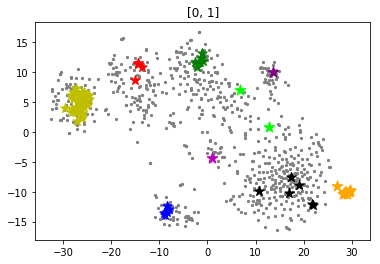

In [79]:
# X_tsne_dd=tsne.fit_transform(1-PCnn_dd)
X_se=X_tsne_dd


dim1,dim2=0,1
plt.scatter(X_se[:,dim1],X_se[:,dim2],s=5,c='gray')



idx=[]
for g in marker_gene_dic['T-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='r')

idx=[]
for g in marker_gene_dic['NK-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='g')

idx=[]
for g in marker_gene_dic['B-cells']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='b')

idx=[]
for g in marker_gene_dic['myeloid']+marker_gene_dic['Innate Immunity']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='k')

idx=[]
for g in ['RPL18', 'RPL4', 'RPL13', 'RPL10A', 'RPL19', 'RPS4X', 'RPS16',
'RPL13A', 'RPS6', 'RPS10', 'RPS21', 'RPS20', 'RPL30', 'RPL27A',
'RPS5', 'RPL5', 'RPL11', 'RPL35A', 'RPL9', 'EEF1B2', 'RPS25',
'RPL31', 'RPL14', 'RPS28', 'RPS15A', 'RPS27A', 'RPL29', 'RPL3',
'RPS18', 'RPLP2', 'RPL36', 'RPS29', 'RPS23', 'RPL7A', 'RPS7',]:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=100,marker='*',c='y')

idx=[]
for g in ['PPBP','RGS18']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='purple')

idx=[]
for g in gene_list_ff:
    if g.startswith('MT-'): idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='orange')



idx=[]
for g in ['CCDC50']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='m')

idx=[]
for g in ['TMSB4X','CD63']:
    if g in data_full.var_names:idx += [np.where(gene_list==g)[0][0]]
plt.scatter(X_se[idx,dim1],X_se[idx,dim2],s=130,marker='*',c='lime')



plt.title(str([dim1,dim2]))
plt.show()

['MAX', 'ODC1', 'LIMS1', 'TUBA4A', 'RGS18', 'CARD19', 'YWHAH', 'GRAP2', 'FERMT3', 'RAP1B', 'SNAP23', 'GSTO1', 'KIF2A', 'RAB11A', 'TPM4', 'TLN1', 'RGS10', 'FAM110A', 'ARF1', 'NT5C3A', 'CDKN2D', 'OST4', 'EIF4G2', 'CTSA', 'PRDX6']


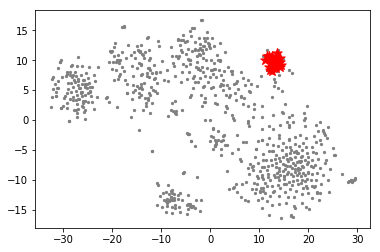

In [77]:
pt=np.array([13,10])
idx_pt=np.argsort([np.linalg.norm(X_tsne_dd[i,:] - pt) for i in range(X_tsne_ml.shape[0])])[:25]
lista=[i for i in gene_list[idx_pt]]
print(lista)
dim1,dim2=0,1
plt.scatter(X_tsne_dd[:,dim1],X_tsne_dd[:,dim2],s=5,c='gray')
plt.scatter(pt[0],pt[1],s=100,marker='*',c='b')
plt.scatter(X_tsne_dd[idx_pt,dim1],X_tsne_dd[idx_pt,dim2],s=100,marker='*',c='r')

plt.show()

ml(+): ['HLA-B', 'HLA-C', 'B2M', 'NKG7', 'GZMA']
dd(+): ['HLA-B', 'HLA-C', 'IL2RG', 'HLA-F', 'MYL12B']


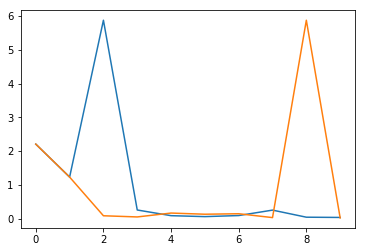

In [222]:
gene='HLA-A'
loc = np.where(gene_list==gene)[0][0]

mn_gn=data_full[:,gene].X.mean()

k=10

ii=np.argsort(PCnn_ml[loc])[::-1]
print('ml(+):',list(gene_list[ii[1:6]]))
pc=[]
cnt=[]
for gene2 in list(gene_list[ii[1:1+k]]):
    loc2 = np.where(gene_list==gene2)[0][0]
    cnt+=[data_full[:,gene2].X.mean()/mn_gn]
    pc+=[PCnn_ml[loc,loc2]]
    
    
plt.plot(cnt)

ii=np.argsort(PCnn_dd[loc])[::-1]
print('dd(+):',list(gene_list[ii[1:6]]))
pc_dd=[]
cnt_dd=[]
for gene2 in list(gene_list[ii[1:1+k]]):
    loc2 = np.where(gene_list==gene2)[0][0]
    cnt_dd+=[data_full[:,gene2].X.mean()/mn_gn]
    pc_dd+=[PCnn_dd[loc,loc2]]
    
    
plt.plot(cnt_dd)
# plt.show()




plt.show()

In [173]:
data_full[:,gene2].X.mean()

ArrayView(2.3131337, dtype=float32)

dd: 0.8876764002527705
ml: 0.30781729586334655


Text(0,0.5,'HLA-F')

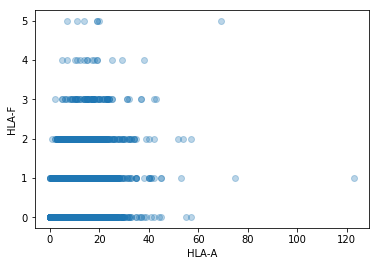

In [224]:
# gene='LCK'
# gene2='ACAP1'
gene='HLA-A'
gene2='HLA-F'
loc = np.where(gene_list==gene)[0][0]
loc2 = np.where(gene_list==gene2)[0][0]
print('dd:',PCnn_dd[loc,loc2])
print('ml:',PCnn_ml[loc,loc2])

x1 = np.array(data_full[:,gene].X)
x2 = np.array(data_full[:,gene2].X)
plt.scatter(x1,x2,alpha=0.3)
plt.xlabel(gene)
plt.ylabel(gene2)

In [116]:

adj_PC_dd = PCnn_dd>0.8

adj_PC_ml = PCnn_ml>0.8

In [125]:
for gene in gene_list[:10]:
    loc = np.where(gene_list==gene)[0][0]
    print(gene,'\n',set(gene_list[adj_PC_ml[loc,:]]).difference(set(gene)),'\n')
    

ISG15 
 {'ISG15'} 

RPL22 
 {'RPL22'} 

ENO1 
 {'ENO1'} 

RBP7 
 {'RBP7'} 

TNFRSF1B 
 {'TNFRSF1B'} 

EFHD2 
 {'EFHD2'} 

CAPZB 
 {'CAPZB'} 

CDA 
 {'CDA'} 

CDC42 
 {'CDC42'} 

RPL11 
 {'RPL11'} 



# Network analysis

In [ ]:
## mi_dd
adj_mi_dd = mi_dd>0.2
np.fill_diagonal(adj_mi_dd,0)
mod_mi_dd = mod_analysis(adj_mi_dd,gene_list,G_name='mi_dd')

## mi_ml
adj_mi_ml = mi_ml>0.02
np.fill_diagonal(adj_mi_ml,0)
mod_mi_ml = mod_analysis(adj_mi_ml,gene_list,G_name='mi_ml')

## PC_dd
adj_PC_dd = PC_dd>0.75
np.fill_diagonal(adj_PC_dd,0)
mod_PC_dd = mod_analysis(adj_PC_dd,gene_list,G_name='PC_dd')

## PC_ml
adj_PC_ml = PC_ml>0.2
np.fill_diagonal(adj_PC_ml,0)
mod_PC_ml = mod_analysis(adj_PC_ml,gene_list,G_name='PC_ml')

# Check the result

In [ ]:
mod_mi_dd

# Check the marker genes 

In [ ]:
check_marker_genes(mod_mi_dd,marker_gene_dic)

# Other code

# Dive into a toy example (mi)

In [ ]:
# temp = ['IL7R','CD3G','CD3E','CD3D','LCK']
temp = ['CD3G','CD3E','CD3D','NKG7','GZMA']
idx_ = get_index(temp,gene_list)
print('mean level')
print(mean_ml[idx_])
print('p0_ml')
print(zero_matrix_ml[idx_,:][:,idx_])
print('p0_dd')
print(zero_matrix_dd[idx_,:][:,idx_])
print('mi_ml')
print(mi_ml[idx_,:][:,idx_])
print('mi_dd')
print(mi_dd[idx_,:][:,idx_])

In [ ]:
Y = np.array(data[:,'NKG7'].X)
plt.figure()
plt.hist(Y,bins=np.linspace(-0.5,9.5,10))
plt.show()

In [ ]:
## mi_dd
adj_mi_dd = mi_dd + mi_ml>0.12
np.fill_diagonal(adj_mi_dd,0)
mod_mi_dd = mod_analysis(adj_mi_dd,gene_list,G_name='mi_dd')

In [ ]:
check_marker_genes(mod_mi_dd,marker_gene_dic)

# Dive into a toy example (PC)

In [ ]:
# temp = ['IL7R','CD3G','CD3E','CD3D','LCK']
temp = ['CD3G','CD3E','CD3D','NKG7','GZMA']
# temp = ['COX7B', 'COX6B1', 'AP2S1', 'ATP6V0B']

PC_dd = shrink_PC(cov_dd,shrink_param=0.0)
idx_ = get_index(temp,gene_list)
print('mean level')
print(mean_ml[idx_])
print('PC_ml')
print(PC_ml[idx_,:][:,idx_])
print('PC_dd')
print(PC_dd[idx_,:][:,idx_])
print('cov_ml')
print(cov_ml[idx_,:][:,idx_])
print('cov_dd')
print(cov_dd[idx_,:][:,idx_])

In [ ]:
## PC_dd
adj_PC_dd = PC_dd>0.8
np.fill_diagonal(adj_PC_dd,0)
mod_PC_dd = mod_analysis(adj_PC_dd,gene_list,G_name='PC_dd')

In [ ]:
check_marker_genes(mod_PC_dd,marker_gene_dic)


In [ ]:
mod_PC_dd

In [ ]:
## PC_dd
adj_PC_dd = (PC_ml>0.6)*(PC_dd<1)
np.fill_diagonal(adj_PC_dd,0)
mod_PC_dd = mod_analysis(adj_PC_dd,gene_list,G_name='PC_dd')